In [42]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="bright",
    style="whitegrid",
    rc=tex_fonts,
)

NUM_SIMS = 5
CONVERGED = False
USE_SIMULATED_TIME = False
MINUTE = 60

if USE_SIMULATED_TIME:
    X_LABEL = "Simulated time, minutes"
else:
    X_LABEL = "Time step number"

data = {
    r"$L = L_{\mathrm{min}}$": load_data("poro_l0", n_newest=NUM_SIMS),
    r"$L = L_{\mathrm{phys}}$": load_data("poro_l1", n_newest=NUM_SIMS),
    "Random": load_data("poro_lrandom", n_newest=NUM_SIMS),
    "Dynamic": load_data("poro_ldynamic", n_newest=NUM_SIMS),
}


save_media_path = None

Loading data:
/home/firedrake/solver_selector/examples/1/performance/poro_l0_13.npy
/home/firedrake/solver_selector/examples/1/performance/poro_l0_14.npy
/home/firedrake/solver_selector/examples/1/performance/poro_l0_15.npy
/home/firedrake/solver_selector/examples/1/performance/poro_l0_16.npy
/home/firedrake/solver_selector/examples/1/performance/poro_l0_17.npy
Loading data:
/home/firedrake/solver_selector/examples/1/performance/poro_l1_10.npy
/home/firedrake/solver_selector/examples/1/performance/poro_l1_11.npy
/home/firedrake/solver_selector/examples/1/performance/poro_l1_12.npy
/home/firedrake/solver_selector/examples/1/performance/poro_l1_13.npy
/home/firedrake/solver_selector/examples/1/performance/poro_l1_14.npy
Loading data:
/home/firedrake/solver_selector/examples/1/performance/poro_lrandom_9.npy
/home/firedrake/solver_selector/examples/1/performance/poro_lrandom_10.npy
/home/firedrake/solver_selector/examples/1/performance/poro_lrandom_11.npy
/home/firedrake/solver_selector/ex

Dynamic 0


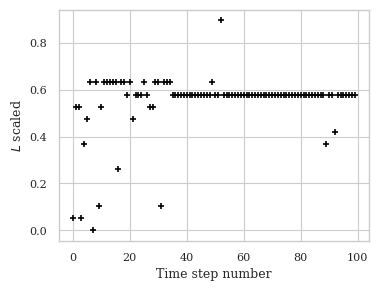

Dynamic 1


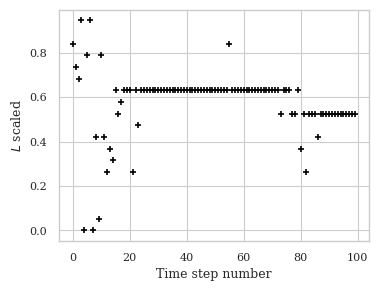

Dynamic 2


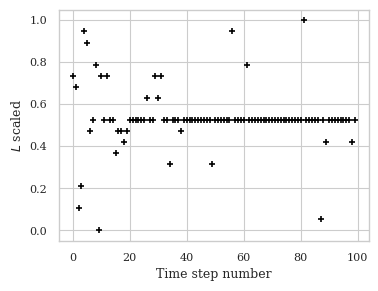

Dynamic 3


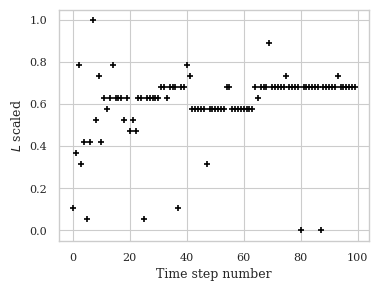

Dynamic 4


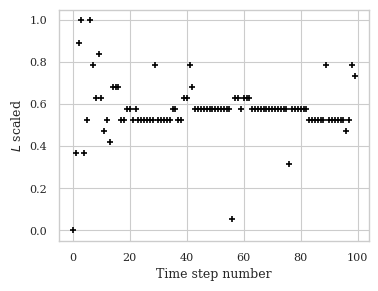

In [43]:
def make_l_factor(data: Sequence[SolverSelectionData], converged=True):
    l_factors = np.array(
        [
            x.config["gmres"]["preconditioner"]["splitting_fixed_stress"]["l_factor"]
            for x in data
        ]
    )
    if converged:
        return l_factors[make_converged_indices(data)]
    return l_factors


for name, values in data.items():
    if name not in ("Dynamic",):
        continue
    for i, value in enumerate(values):
        print(name, i)
        plt.figure(figsize=(4, 3))
        l_factors = make_l_factor(value, converged=CONVERGED)
        x = make_simulation_time(values[0], converged=CONVERGED) / MINUTE
        if not USE_SIMULATED_TIME:
            x = np.arange(len(l_factors))
        plt.scatter(x, l_factors, label=name, color="black", marker="+")

        plt.ylabel("$L$ scaled")
        plt.xlabel(X_LABEL)
        plt.show()
        if save_media_path is not None:
            plt.savefig(
                save_media_path / f"poro_lfactor_dt_{name}_{i}.pdf", bbox_inches="tight"
            )

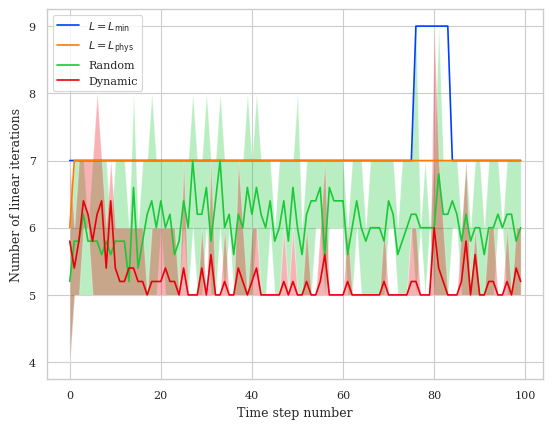

In [44]:
plt.figure()
for name, values in data.items():
    num_iters = [make_num_linear_iters(perf, converged=CONVERGED) for perf in values]
    mean = np.mean(num_iters, axis=0)
    max = np.max(num_iters, axis=0)
    min = np.min(num_iters, axis=0)
    x = make_simulation_time(values[0], converged=CONVERGED) / MINUTE
    if not USE_SIMULATED_TIME:
        x = np.arange(len(mean))
    plt.fill_between(x, min, max, alpha=.3)
    plt.plot(x, mean, label=name)
plt.xlabel(X_LABEL)
plt.ylabel('Number of linear iterations')
plt.legend()

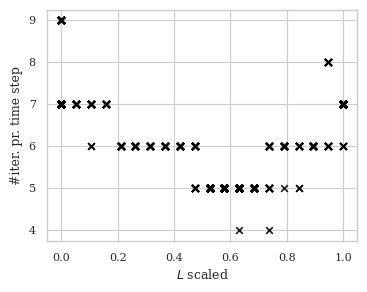

In [45]:
l_factors = []
num_iters = []
plt.figure(figsize=(4, 3))

for name, values in data.items():
    for value in values:
        l_factors.extend(make_l_factor(value).tolist())
        num_iters.extend(make_num_linear_iters(value).tolist())
plt.scatter(
    l_factors, num_iters, label=name, alpha=0.9, color="black", marker="x"
)
plt.ylabel("#iter. pr. time step")
plt.xlabel("$L$ scaled")
plt.show()
if save_media_path is not None:
    plt.savefig(save_media_path / "poro_iters.pdf", bbox_inches="tight")

$L = L_{\mathrm{min}}$ 41.40888314247131 2.0514261722564697
$L = L_{\mathrm{phys}}$ 40.220467472076415 0.48769664764404297
Random 36.432244825363156 1.3099141120910645
Dynamic 32.67836971282959 0.843440055847168


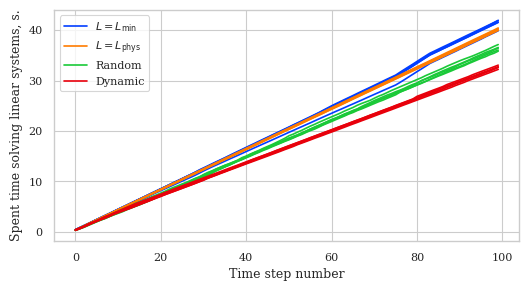

In [46]:
color_iter = -1
plt.figure(figsize=(6, 3))
for name, values in data.items():
    results = [make_solve_linear_system_time(perf, converged=CONVERGED) for perf in values]
    x = np.arange(len(results[0]))
    if USE_SIMULATED_TIME:
        x = make_simulation_time(values[0], converged=CONVERGED) / MINUTE
    color_iter += 1
    make_label = True
    total = []
    for result in results:
        result = np.cumsum(result)
        total.append(result[-1])
        if make_label:
            plt.plot(x, result, color=f"C{color_iter}", label=name)
            make_label = False
        else:
            plt.plot(x, result, color=f"C{color_iter}")
    print(name, np.mean(total), np.max(total) - np.min(total))

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")
if save_media_path is not None:
    plt.savefig(save_media_path / "poro_performance.pdf", bbox_inches="tight")

$L = L_{\mathrm{min}}$ 41.40888314247131 2.0514261722564697
$L = L_{\mathrm{phys}}$ 40.220467472076415 0.48769664764404297
Random 36.432244825363156 1.3099141120910645
Dynamic 32.67836971282959 0.843440055847168


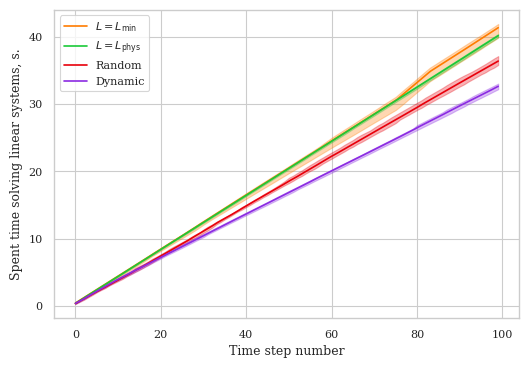

In [47]:
color_iter = 0
best_time = float("inf")
plt.figure(figsize=(6, 4))
for name, values in data.items():
    results = []
    times = []
    color_iter += 1

    for perf in values:
        res = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )

        results.append(res)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / MINUTE)
        else:
            times.append(np.arange(len(res)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, results):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    if mean[-1] < best_time:
        best_time = mean[-1]
        best = mean
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

$L = L_{\mathrm{min}}$ 41.40888314247131 2.0514261722564697
$L = L_{\mathrm{phys}}$ 40.220467472076415 0.48769664764404297
Random 36.432244825363156 1.3099141120910645
Dynamic 32.67836971282959 0.843440055847168


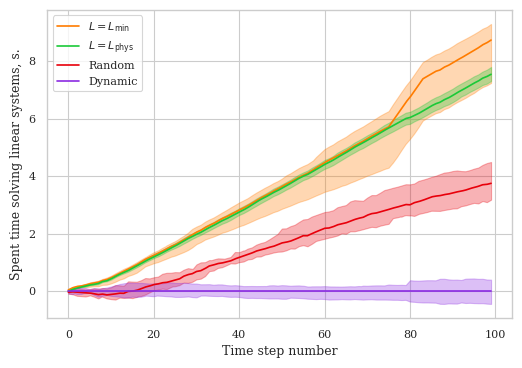

In [48]:
color_iter = 0
plt.figure(figsize=(6, 4))
for name, values in data.items():
    results = []
    times = []
    color_iter += 1

    for perf in values:
        res = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )

        results.append(res)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / MINUTE)
        else:
            times.append(np.arange(len(res)))


    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, results):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list) - best
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")